In [1]:
import os
import cv2
import itertools
import multiprocessing
import concurrent.futures
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection  import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import ConfusionMatrixDisplay
from keras.models import load_model
from keras.losses import CategoricalCrossentropy
from sklearn import svm
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
path = '/ISIC_datasets/ISIC_2018/'
df = pd.read_csv(path + 'ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

In [4]:
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevus',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'BKL': 'Benign keratosis',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesion',
}
classes = [value for key, value in lesion_type_dict.items()]
label_dict = dict([(column, i) for i, column in enumerate(df.columns[1:])])
lesion_tag_dict = dict([(i, column) for i, column in enumerate(df.columns[1:])])

In [5]:
CorrectedLabels = df[df.columns[1:]].to_numpy()
CorrectedLabels = np.argmax(CorrectedLabels, axis=1)
df['label'] = CorrectedLabels
df.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  label
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0      0

In [6]:
df.drop(df.columns[1:8], axis=1, inplace=True)
df.head()

image  label
0  ISIC_0024306      1
1  ISIC_0024307      1
2  ISIC_0024308      1
3  ISIC_0024309      1
4  ISIC_0024310      0

In [7]:
df['disease'] = (df['label'].map(lesion_tag_dict.get)).map(lesion_type_dict.get)
df.head()

image  label            disease
0  ISIC_0024306      1  Melanocytic nevus
1  ISIC_0024307      1  Melanocytic nevus
2  ISIC_0024308      1  Melanocytic nevus
3  ISIC_0024309      1  Melanocytic nevus
4  ISIC_0024310      0           Melanoma

In [13]:
df.loc[df['image'] == 'ISIC_0029760']

image  label         disease
5454  ISIC_0029760      5  Dermatofibroma

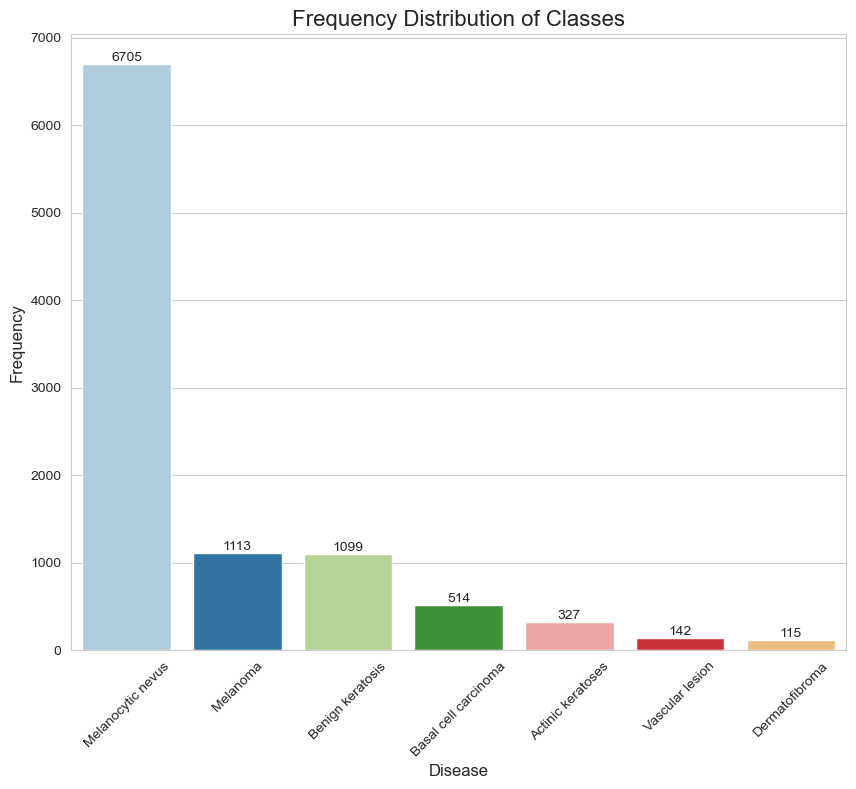

In [8]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(10,8))
ax = sns.countplot(x = 'disease', data = df, order = df['disease'].value_counts().index, palette='Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Frequency Distribution of Classes', size=16)
plt.xticks(rotation=45)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.show()

In [9]:
max_images_per_class = {
    'MEL': 2000,
    'NV': 2000,
    'BCC': 2000,
    'AKIEC': 1500,
    'BKL': 2000,
    'DF': 1000,
    'VASC': 1000,
}

In [10]:
images_to_be_cropped = df['disease'].value_counts()[0] - max_images_per_class['NV']
for index, row in df.iterrows():
    if  images_to_be_cropped > 0 and row['label'] == label_dict['NV']:
        images_to_be_cropped -= 1
        df.drop(index=index, inplace=True)

In [11]:
df['disease'].value_counts()

Melanocytic nevus       2000
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesion          142
Dermatofibroma           115
Name: disease, dtype: int64

In [12]:
def dataset_summary(class_counts):
    # Print the number of images in each class
    print("Dataset Summary")
    print("-" * 60)
    print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
    print("-" * 60)
    for class_label, class_name in lesion_type_dict.items():
        count = class_counts[class_name]
        print(f"{class_label:<15} {class_name:<30} {count:<10}")
    print("-" * 60)
    print(f"{'Total':<45} {sum(class_counts):<10}")

In [13]:
class_counts = df['disease'].value_counts()
dataset_summary(class_counts)

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
MEL             Melanoma                       1113      
NV              Melanocytic nevus              2000      
BCC             Basal cell carcinoma           514       
AKIEC           Actinic keratoses              327       
BKL             Benign keratosis               1099      
DF              Dermatofibroma                 115       
VASC            Vascular lesion                142       
------------------------------------------------------------
Total                                         5310      


In [14]:
image_size=224

In [15]:
max_workers = multiprocessing.cpu_count()

def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((image_size,image_size)))

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, (path + 'train/' + df['image'] + '.jpg').tolist()))

df['image_array'] = image_arrays
del image_arrays
df.head()

image  label           disease  \
4   ISIC_0024310      0          Melanoma   
6   ISIC_0024312      4  Benign keratosis   
7   ISIC_0024313      0          Melanoma   
9   ISIC_0024315      0          Melanoma   
12  ISIC_0024318      5    Dermatofibroma   

                                          image_array  
4   [[[71, 34, 38], [72, 32, 39], [71, 32, 38], [6...  
6   [[[171, 136, 167], [172, 137, 170], [173, 139,...  
7   [[[186, 140, 152], [186, 141, 155], [187, 143,...  
9   [[[148, 123, 142], [150, 129, 148], [149, 131,...  
12  [[[231, 177, 166], [230, 174, 166], [232, 176,...

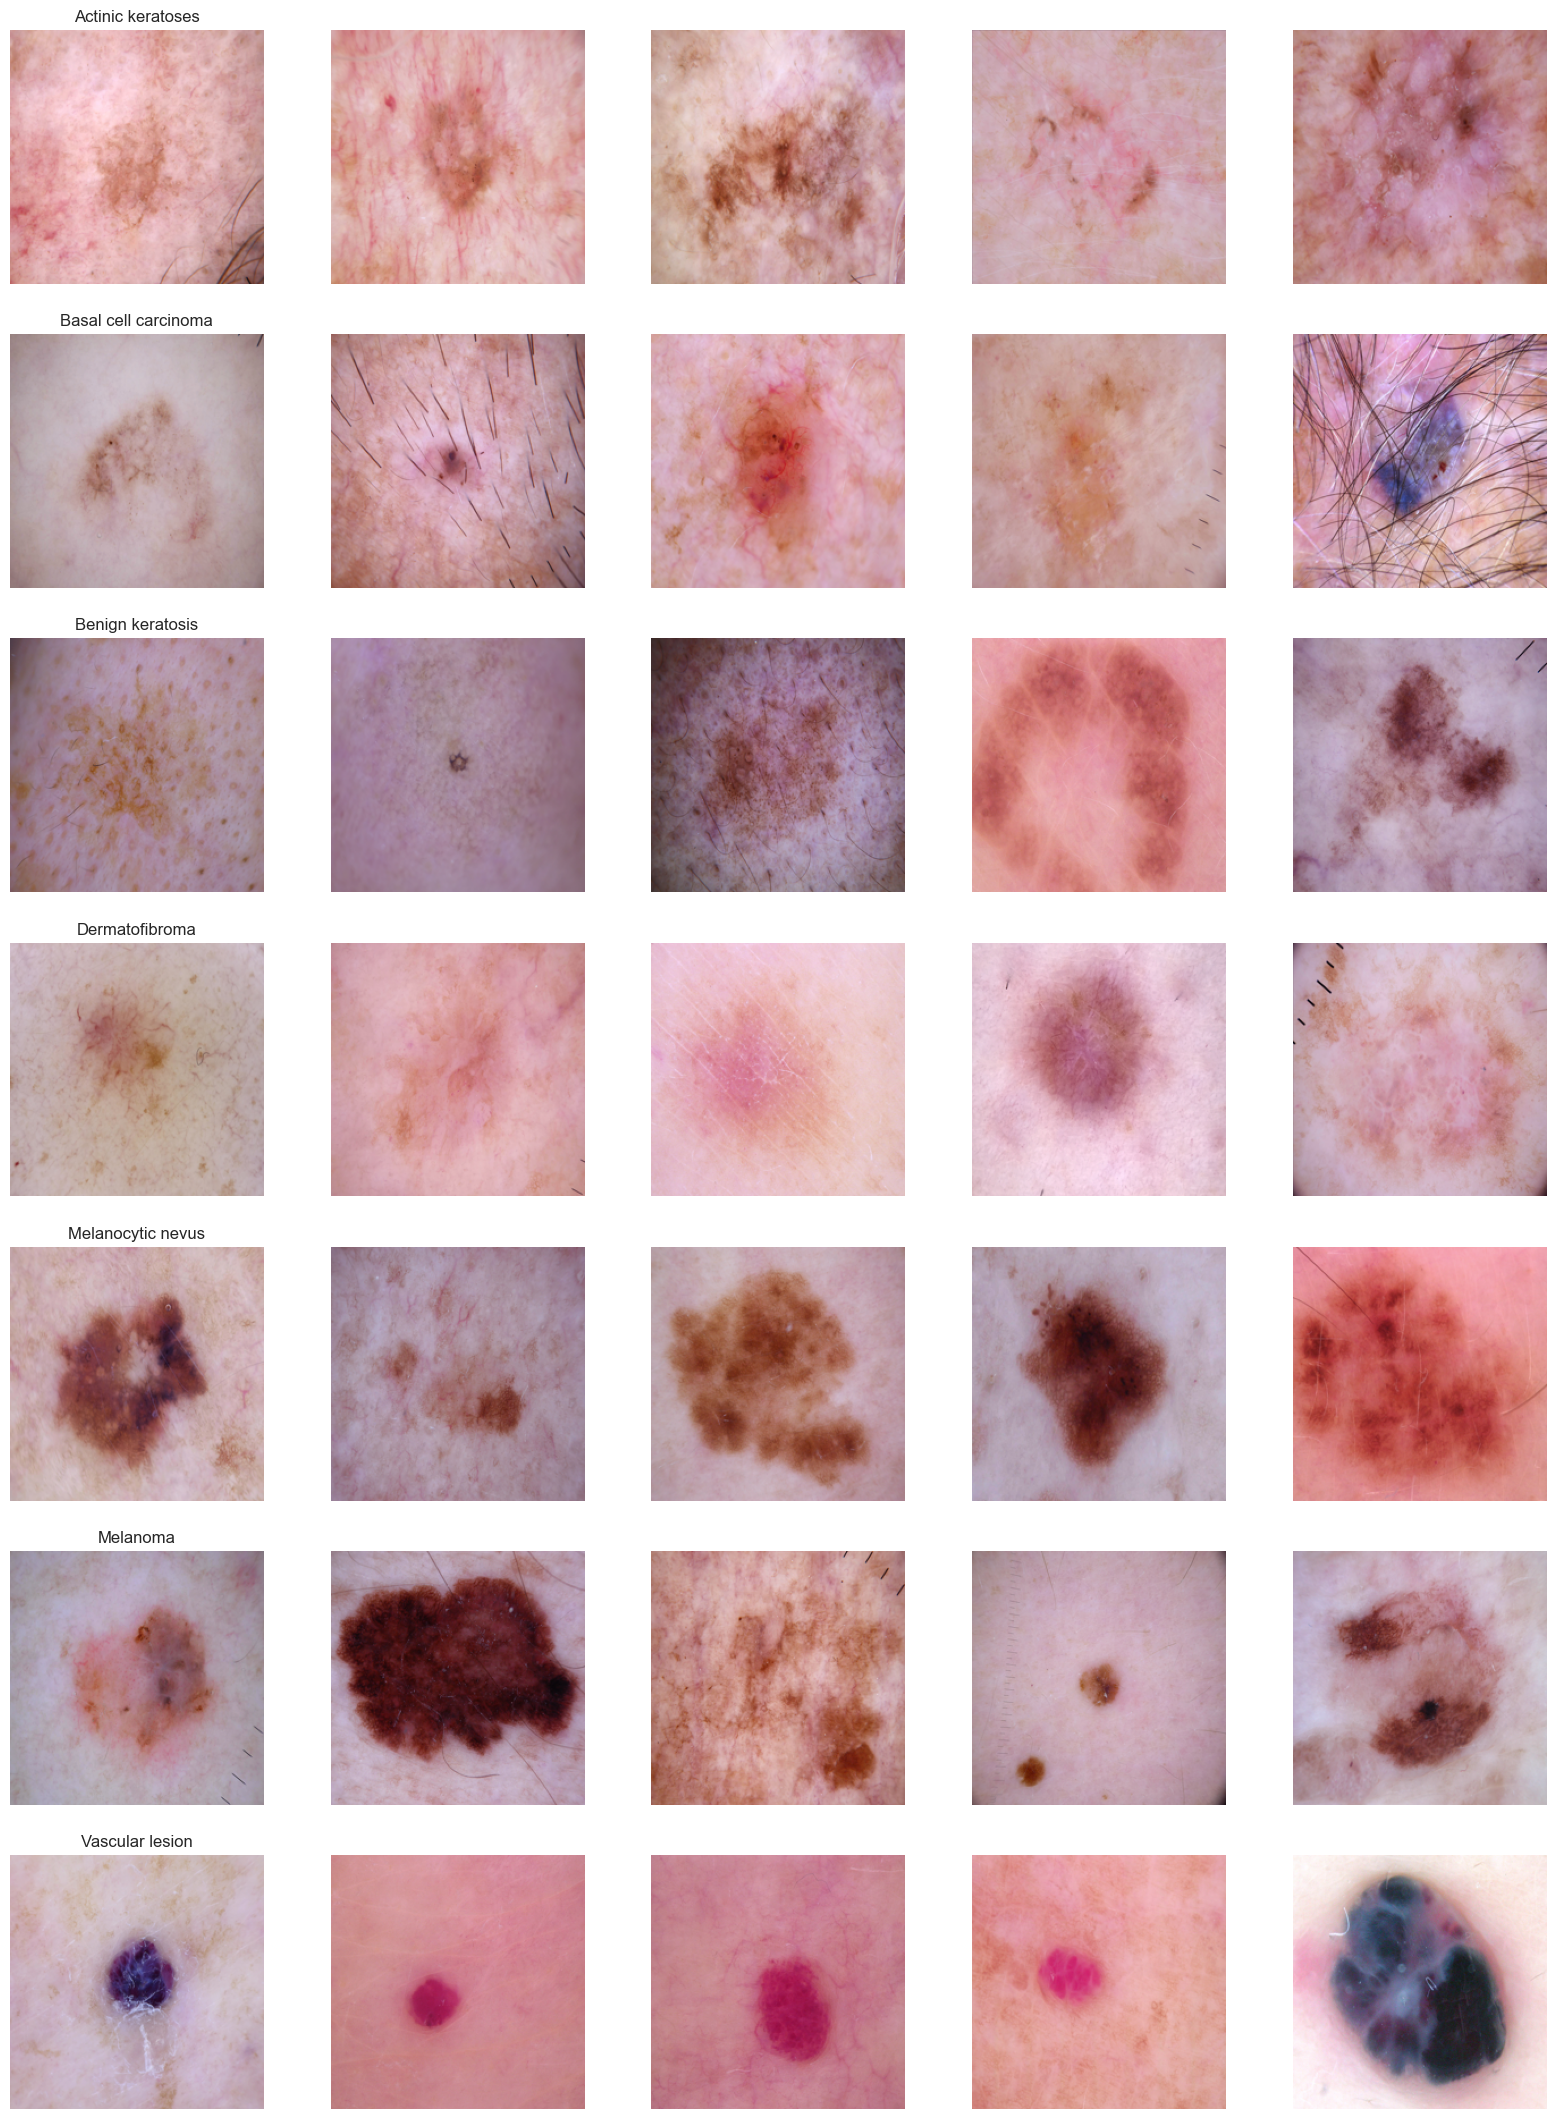

In [16]:
n_samples = 5
n_diseases = len(lesion_type_dict)
fig, m_axs = plt.subplots(n_diseases, n_samples, figsize = (4*n_samples, 3*9))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['disease']).groupby('disease')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=11223344).iterrows()):
        c_ax.imshow(c_row['image_array'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [17]:
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode='nearest')

In [22]:
augmented_df = pd.DataFrame(columns=['image', 'label', 'disease'])
array_of_images = []
for class_label in df['label'].unique():
    image_arrays = df.loc[df['label'] == class_label, 'image_array'].values
    num_images_needed = max_images_per_class[lesion_tag_dict[class_label]] - len(image_arrays)
    if num_images_needed > 0:
        np.random.seed(0)
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        for image_array in selected_images:
            image_tensor = np.expand_dims(image_array, axis=0)
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                array_of_images.append(augmented_image_array)
                new_row = {'image':None, 'label':class_label, 'disease':lesion_type_dict[lesion_tag_dict[class_label]]}
                augmented_df.loc[len(augmented_df)] = new_row
                
augmented_df['image_array'] = array_of_images
augmented_df.head()

image  label   disease                                        image_array
0  None      0  Melanoma  [[[71, 57, 68], [69, 56, 66], [68, 55, 65], [6...
1  None      0  Melanoma  [[[184, 147, 143], [184, 147, 143], [184, 147,...
2  None      0  Melanoma  [[[154, 118, 112], [154, 118, 112], [154, 118,...
3  None      0  Melanoma  [[[98, 66, 69], [95, 65, 68], [93, 64, 70], [9...
4  None      0  Melanoma  [[[186, 154, 156], [184, 154, 153], [184, 152,...

In [ ]:
df = pd.concat([df, augmented_df])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
del augmented_df
df.head()

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(10,8))
ax = sns.countplot(x = 'disease', data = df, order = df['disease'].value_counts().index, palette='Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45)
plt.xlabel('Disease', size=12)
plt.ylabel('Number of Images', size=12)
plt.show()

In [ ]:
X = df.drop(columns=['image','label','disease'],axis=1)
X = X['image_array'].to_list()
y = df['label'].to_list()

In [ ]:
del df

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
del X
del y

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1111727505, random_state=42) # 80% 10% 10%

In [ ]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
np.save("x_train",x_train)
np.save("y_train", y_train)
np.save("x_val", x_val)
np.save("y_val", y_val)
np.save("x_test", x_test)
np.save("y_test", y_test)

In [20]:
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))

In [ ]:
np.save("y_train", y_train)
np.save("x_val", x_val)
np.save("y_val", y_val)
np.save("x_test", x_test)
np.save("y_test", y_test)

In [5]:
x_train = np.load('x_train.npy')
x_train = x_train.astype('float32') / 255
np.save("x_train",x_train)

In [26]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((9199, 224, 224, 3), (1150, 224, 224, 3), (9199, 7), (1150, 7))

In [29]:
# Reset

In [6]:
x_val = np.load('x_val.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')

In [7]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_train, y_train, 8)
val_gen = DataGenerator(x_val, y_val, 8)

In [8]:
def build_model():
    baseModel = Xception(weights= 'imagenet', include_top = False, input_shape=(224, 224, 3))
    for layer in baseModel.layers:
        layer.trainable = True
    headModel = baseModel.output
    headModel = Flatten()(headModel)
    
    headModel = Dense(512)(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Activation('relu')(headModel)
    
    headModel = Dense(128)(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Activation('relu')(headModel)
    
    headModel = Dense(52)(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Activation('relu')(headModel)
    
    headModel = Dense(16,)(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Activation('relu')(headModel)
    
    headModel = Dense(len(lesion_type_dict), activation="softmax")(headModel)
    
    x = Model(baseModel.inputs,outputs=headModel)

    optimizers = Adam(learning_rate=  0.0001)
    x.compile(loss = 'categorical_crossentropy', optimizer = optimizers, metrics = ['accuracy'])
    return x

model= build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [42]:
history = model.fit(train_gen, validation_data = val_gen, epochs = 30)

1150/1150 [==============================] - 182s 158ms/step - loss: 0.0669 - accuracy: 0.9842 - val_loss: 0.7194 - val_accuracy: 0.8766


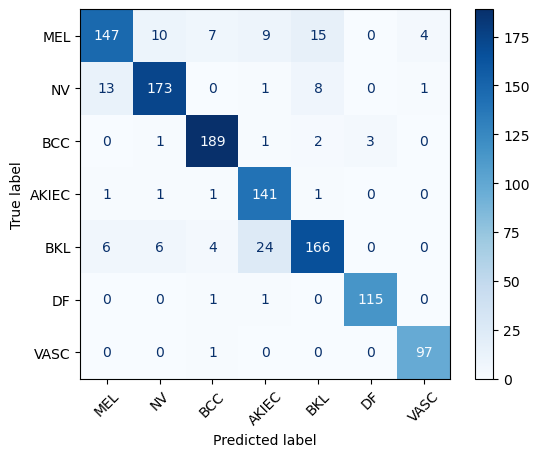

                      precision    recall  f1-score   support

            Melanoma       0.88      0.77      0.82       192
   Melanocytic nevus       0.91      0.88      0.89       196
Basal cell carcinoma       0.93      0.96      0.95       196
   Actinic keratoses       0.80      0.97      0.88       145
    Benign keratosis       0.86      0.81      0.83       206
      Dermatofibroma       0.97      0.98      0.98       117
     Vascular lesion       0.95      0.99      0.97        98

            accuracy                           0.89      1150
           macro avg       0.90      0.91      0.90      1150
        weighted avg       0.90      0.89      0.89      1150

Current Label: Melanoma
	Precision: 0.8802395209580839
	Sensitivity: 0.765625
	Specificity: 0.9791231732776617
	Accuracy: 0.9434782608695652

Current Label: Melanocytic nevus
	Precision: 0.9057591623036649
	Sensitivity: 0.8826530612244898
	Specificity: 0.9811320754716981
	Accuracy: 0.9643478260869566

Current Labe

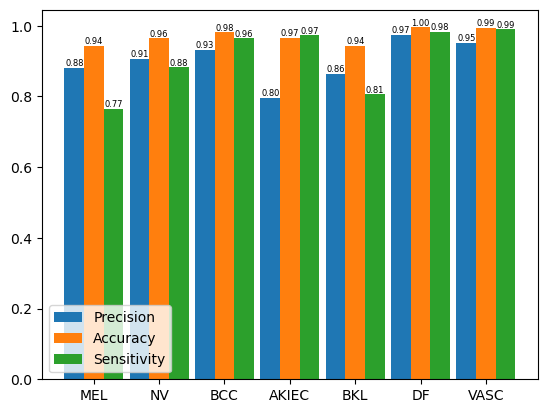

In [43]:
get_metrics(x_test, y_test)

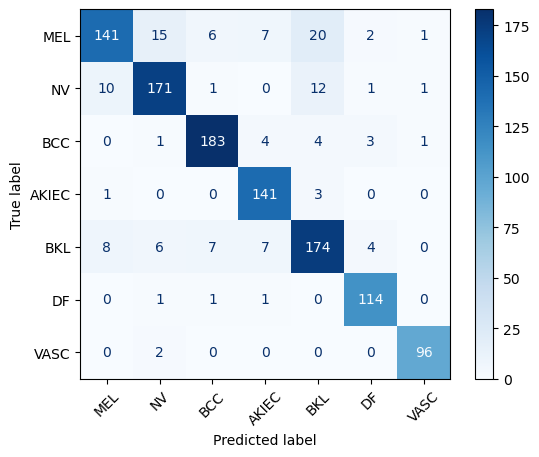

                      precision    recall  f1-score   support

            Melanoma       0.88      0.73      0.80       192
   Melanocytic nevus       0.87      0.87      0.87       196
Basal cell carcinoma       0.92      0.93      0.93       196
   Actinic keratoses       0.88      0.97      0.92       145
    Benign keratosis       0.82      0.84      0.83       206
      Dermatofibroma       0.92      0.97      0.95       117
     Vascular lesion       0.97      0.98      0.97        98

            accuracy                           0.89      1150
           macro avg       0.90      0.90      0.90      1150
        weighted avg       0.89      0.89      0.89      1150

Current Label: Melanoma
	Precision: 0.88125
	Sensitivity: 0.734375
	Specificity: 0.9801670146137788
	Accuracy: 0.9391304347826087

Current Label: Melanocytic nevus
	Precision: 0.8724489795918368
	Sensitivity: 0.8724489795918368
	Specificity: 0.9737945492662474
	Accuracy: 0.9565217391304348

Current Label: Basal ce

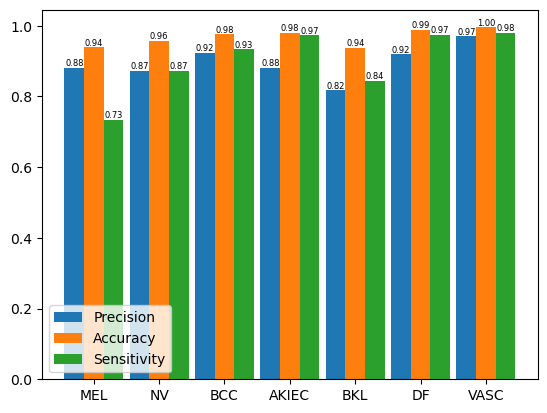

In [41]:
get_metrics(x_test, y_test)

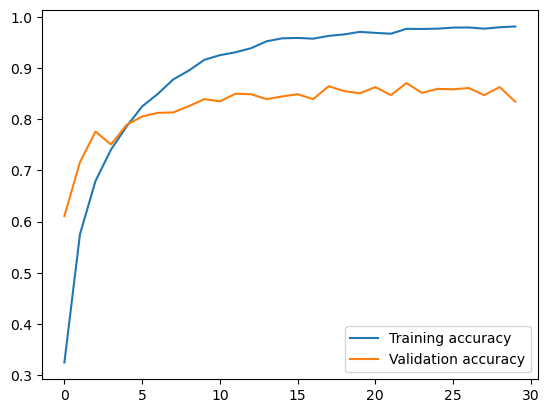

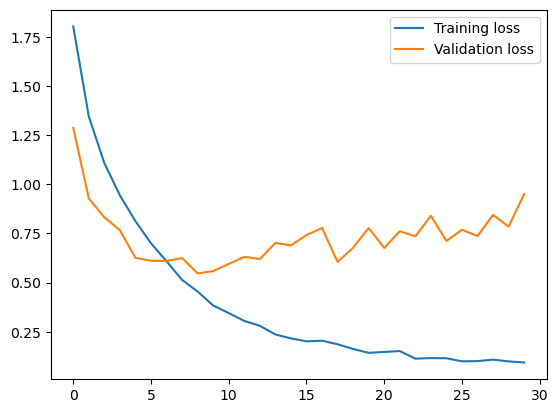

In [10]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

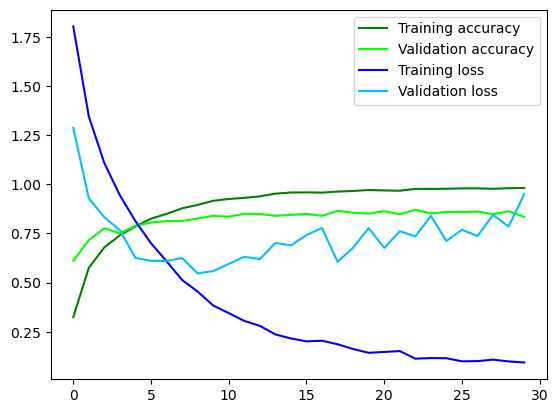

In [11]:
plt.plot(history.history['accuracy'], label='Training accuracy', color = "g")
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color = "lime")
plt.plot(history.history['loss'], label='Training loss', color = "b")
plt.plot(history.history['val_loss'], label='Validation loss', color = "deepskyblue")
plt.legend()
plt.show()

In [12]:
model.save('Xception_model_A_Batch.h5')

C:\Users\Rayver\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [13]:
del x_val, y_val

In [14]:
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [15]:
def get_svm_predictions(x_train_features, x_test_features, y_train, y_test):
    x_train_features  = x_train_features.reshape(x_train_features.shape[0], -1)
    x_test_features = x_test_features.reshape(x_test_features.shape[0], -1)

    clf = svm.SVC(kernel="rbf")
    clf.fit(x_train_features, np.argmax(y_train, axis=1))
    return clf.predict(x_test_features)

def plot_confusion_matrix(y_test, y_pred, cmap = plt.cm.Blues):
    ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=np.argmax(y_test, axis=1), cmap=cmap)
    plt.xticks(np.arange(len(classes)), lesion_type_dict, rotation=45)
    plt.yticks(np.arange(len(classes)), lesion_type_dict)
    plt.grid(False)
    plt.show()
    
def plot_classification_report(y_test, y_pred, target_names):
    print(classification_report(y_pred=y_pred, y_true= np.argmax(y_test, axis=1), target_names=target_names))

def create_and_plot_confusion_matrix(y_test, y_pred):
    def plot_cm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        #plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, lesion_type_dict, rotation=45)
        plt.yticks(tick_marks, lesion_type_dict)

        if normalize:
            cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals = 2)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.grid(False)
        plt.show()
    cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred)
    plot_cm(cm, normalize=False, classes = classes)
    
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

def print_multiclass_cm_metrics(y_test, y_pred, visualize = False, printable = True, plottable=True):
    mcm = multilabel_confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred)
    accuracy = []
    sensitivity = []
    specificity = []
    precision = []
    
    for i in range(len(mcm)):
        if printable:
            print(f'Current Label: {lesion_type_dict[lesion_tag_dict[i]]}')
        if visualize:
            print(mcm[i])
        tp = mcm[i][1,1]
        tn = mcm[i][0,0]
        fp = mcm[i][0,1]
        fn = mcm[i][1,0]
        
        current_accuracy = (tp+tn)/(tp+tn+fp+fn)
        current_sensitivity = (tp)/(tp+fn)
        current_specificity = (tn)/(tn+fp)
        current_precision = (tp)/(tp+fp)
        if printable:
            print(f"\tPrecision: {current_precision}")
            print(f"\tSensitivity: {current_sensitivity}")
            print(f"\tSpecificity: {current_specificity}")
            print(f"\tAccuracy: {current_accuracy}")
            print()
        accuracy.append(current_accuracy)
        precision.append(current_precision)
        sensitivity.append(current_sensitivity)
        specificity.append(current_specificity)
    
    width = 0.3
    x = np.arange(len(classes))
    font_size=6
    if plottable:
        plt.bar(x-width,precision, width = width, label='Precision')
        plt.bar(x, accuracy, width=width, label='Accuracy')
        plt.bar(x+width, sensitivity, width=width, label='Sensitivity')
        for x1, x2, x3, y1, y2, y3 in zip(x-width, x, x+width, precision, accuracy, sensitivity):
            plt.text(x1, y1, '%.2f' % y1, ha='center', va='bottom', fontsize=font_size)
            plt.text(x2, y2, '%.2f' % y2, ha='center', va='bottom', fontsize=font_size)
            plt.text(x3, y3, '%.2f' % y3, ha='center', va='bottom', fontsize=font_size)
        plt.xticks(x, lesion_type_dict)
        plt.legend(loc='lower left')
        plt.show()
def get_metrics(x, y):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)
    plot_confusion_matrix(y_test=y, y_pred=y_pred)
    plot_classification_report(y_pred=y_pred, y_test=y, target_names=classes)
    print_multiclass_cm_metrics(y_test=y,y_pred=y_pred)

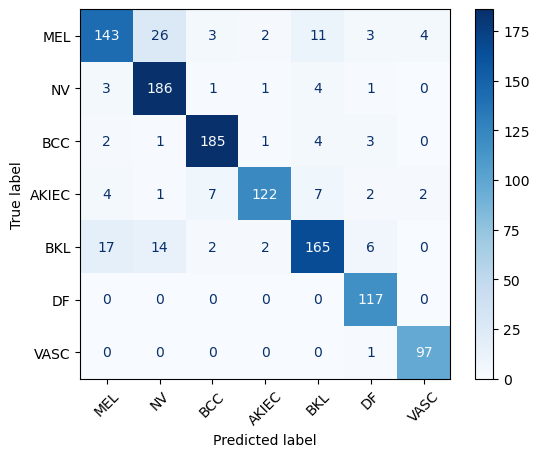

                      precision    recall  f1-score   support

            Melanoma       0.85      0.74      0.79       192
   Melanocytic nevus       0.82      0.95      0.88       196
Basal cell carcinoma       0.93      0.94      0.94       196
   Actinic keratoses       0.95      0.84      0.89       145
    Benign keratosis       0.86      0.80      0.83       206
      Dermatofibroma       0.88      1.00      0.94       117
     Vascular lesion       0.94      0.99      0.97        98

            accuracy                           0.88      1150
           macro avg       0.89      0.90      0.89      1150
        weighted avg       0.88      0.88      0.88      1150

Current Label: Melanoma
	Precision: 0.8461538461538461
	Sensitivity: 0.7447916666666666
	Specificity: 0.9728601252609603
	Accuracy: 0.9347826086956522

Current Label: Melanocytic nevus
	Precision: 0.8157894736842105
	Sensitivity: 0.9489795918367347
	Specificity: 0.9559748427672956
	Accuracy: 0.9547826086956521

Cu

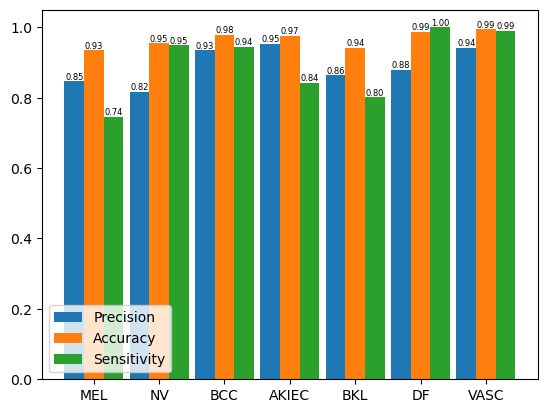

In [37]:
get_metrics(x_test, y_test)

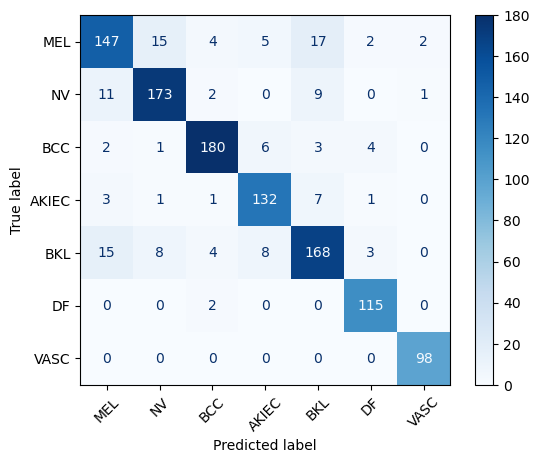

                      precision    recall  f1-score   support

            Melanoma       0.83      0.77      0.79       192
   Melanocytic nevus       0.87      0.88      0.88       196
Basal cell carcinoma       0.93      0.92      0.93       196
   Actinic keratoses       0.87      0.91      0.89       145
    Benign keratosis       0.82      0.82      0.82       206
      Dermatofibroma       0.92      0.98      0.95       117
     Vascular lesion       0.97      1.00      0.98        98

            accuracy                           0.88      1150
           macro avg       0.89      0.90      0.89      1150
        weighted avg       0.88      0.88      0.88      1150

Current Label: Melanoma
	Precision: 0.8258426966292135
	Sensitivity: 0.765625
	Specificity: 0.9676409185803758
	Accuracy: 0.9339130434782609

Current Label: Melanocytic nevus
	Precision: 0.8737373737373737
	Sensitivity: 0.8826530612244898
	Specificity: 0.9737945492662474
	Accuracy: 0.9582608695652174

Current Labe

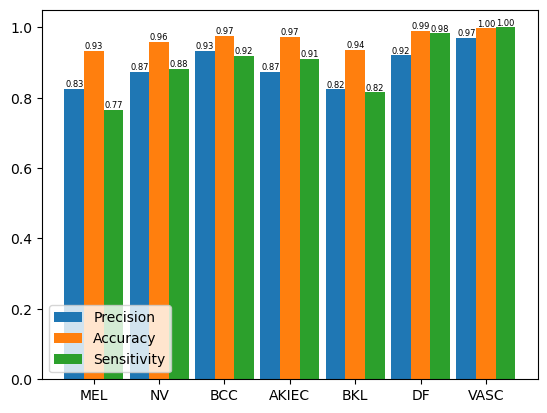

In [33]:
get_metrics(x_test, y_test)

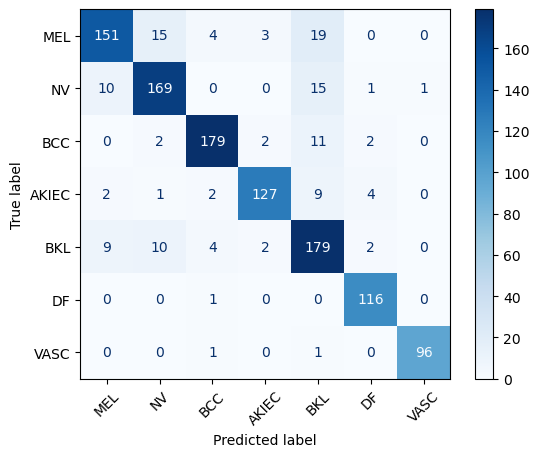

                      precision    recall  f1-score   support

            Melanoma       0.88      0.79      0.83       192
   Melanocytic nevus       0.86      0.86      0.86       196
Basal cell carcinoma       0.94      0.91      0.93       196
   Actinic keratoses       0.95      0.88      0.91       145
    Benign keratosis       0.76      0.87      0.81       206
      Dermatofibroma       0.93      0.99      0.96       117
     Vascular lesion       0.99      0.98      0.98        98

            accuracy                           0.88      1150
           macro avg       0.90      0.90      0.90      1150
        weighted avg       0.89      0.88      0.88      1150

Current Label: Melanoma
	Precision: 0.877906976744186
	Sensitivity: 0.7864583333333334
	Specificity: 0.9780793319415448
	Accuracy: 0.9460869565217391

Current Label: Melanocytic nevus
	Precision: 0.8578680203045685
	Sensitivity: 0.8622448979591837
	Specificity: 0.9706498951781971
	Accuracy: 0.9521739130434783

Cur

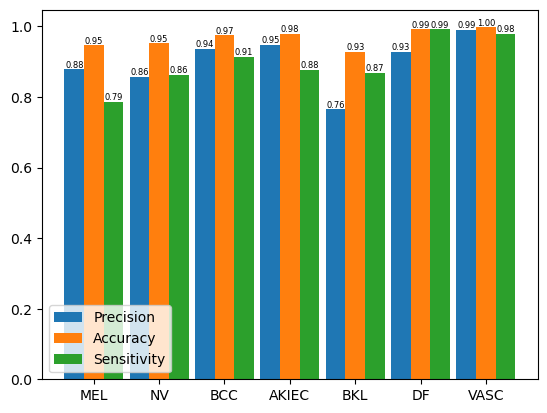

In [20]:
get_metrics(x_test, y_test)

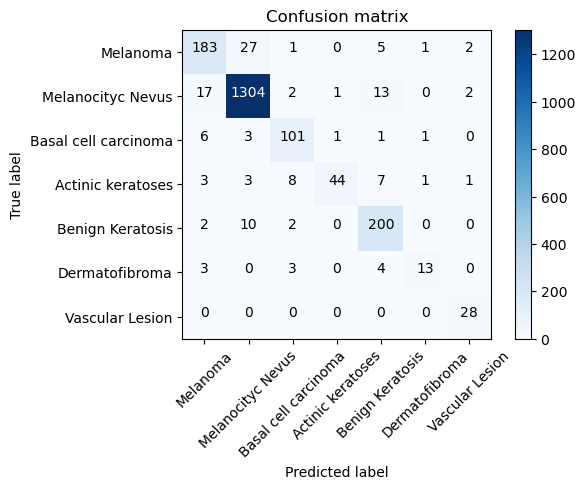

In [25]:
print(classification_report(Y_true, Y_pred_classes, target_names=classes))

                      precision    recall  f1-score   support

            Melanoma       0.86      0.84      0.85       219
   Melanocityc Nevus       0.97      0.97      0.97      1339
Basal cell carcinoma       0.86      0.89      0.88       113
   Actinic keratoses       0.96      0.66      0.78        67
    Benign Keratosis       0.87      0.93      0.90       214
      Dermatofibroma       0.81      0.57      0.67        23
     Vascular Lesion       0.85      1.00      0.92        28

            accuracy                           0.94      2003
           macro avg       0.88      0.84      0.85      2003
        weighted avg       0.94      0.94      0.93      2003

